In [1]:
%load_ext autoreload
%autoreload 2

import time
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import AcceptanceDataset
from memflow.read_data import utils
from memflow.models.classifier import BinaryClassifier

from memflow.HH.HH import *
from memflow.HH.ttbar import *
from memflow.HH.DY import *
from memflow.HH.ZZ import *
from memflow.HH.ZH import *
from memflow.HH.ST import *

from memflow.callbacks.classifier_callbacks import *

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

# Generic dataset maker 

In [2]:
def make_acceptance_dataset(files,treename,hard_cls,reco_cls,selection,N=None):
    # Hard data #
    print ('Hard data loading')
    hard_data = RootData(
        files = files,
        treenames = treename,
        lazy = True,
        N = N,
    )
    print (f'\t... done : {hard_data.events} events')
    
    # Reco data #
    print ('Reco data loading')
    reco_data = RootData(
        files = files,
        treenames = ['reco_DL;1'],
        lazy = True,
        N = N,
    )
    print (f'\t... done : {reco_data.events} events')

    print ('Initial :',reco_data.events)
    
    reco_data.cut(
        np.logical_and.reduce(
            (
                reco_data['flag_SR']==1, 
                reco_data['flag_resolved']==1,
                reco_data['n_AK4']<= 4,
            )
        )
    )
    print ('Resolved SR :',reco_data.events)
    
    # Hard dataset #
    print ('Hard dataset')
    hard_dataset = hard_cls(
        data = hard_data,
        selection = selection,
        coordinates = 'cylindrical',
        apply_boost = False,
        apply_preprocessing = True,
        build = True,
        dtype = torch.float32,
    )
    print ('\t... done')
    print (hard_dataset)
    
    # Acceptance dataset #
    print ('Acceptance dataset')
    acceptance_dataset = AcceptanceDataset(
        hard_dataset = hard_dataset,
        reco_data = reco_data,
        intersection_branch = 'event',
    )
    print ('\t... done')
    
    return acceptance_dataset

# Training #

In [4]:
dataset = make_acceptance_dataset(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root',     

        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2017/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2017/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2017/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2017/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root', 
    ],
    treename = 'gen_HH;1',
    hard_cls = HHbbWWDoubleLeptonHardDataset,
    reco_cls = HHbbWWDoubleLeptonRecoDataset,
    selection = [
        'final_states',
    ],
    N = int(1e6),
)
suffix = 'HH'
# dataset = make_acceptance_dataset(
#     files = [
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/TTTo2L2Nu.root',
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/TTTo2L2Nu.root',
#     ],
#     treename = 'gen_TT;1',
#     hard_cls = TTDoubleLeptonHardDataset,
#     reco_cls = TTDoubleLeptonRecoDataset,
#     N = int(1e6),
# )
# dataset = make_acceptance_dataset(
#     files = [
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/DYJetsToLL_M-10to50.root',
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/DYJetsToLL_M-50.root',
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/DYToLL_0J.root',
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/DYToLL_1J.root',
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/DYToLL_2J.root',
#     ],
#     treename = 'gen_DY;1',
#     hard_cls = DYDoubleLeptonHardDataset,
#     reco_cls = DYDoubleLeptonRecoDataset,
#     selection = [
#         'final_states',
#         'ISR',
#     ],
#     N = int(1e5),
# )
# suffix = 'DY'
# dataset = make_acceptance_dataset(
#     files = [
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/ZZTo2L2Q.root',
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2017/results/ZZTo2L2Q.root',
#         #'/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2018/results/ZZTo2L2Q.root',
#     ],
#     treename = 'gen_ZZ;1',
#     hard_cls = ZZDoubleLeptonHardDataset,
#     reco_cls = ZZDoubleLeptonRecoDataset,
#     N = int(1e6),
# )
# suffix = 'ZZ'
# dataset = make_acceptance_dataset(
#     files = [
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2016/results/ZH_HToBB_ZToLL.root',
#         '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2017/results/ZH_HToBB_ZToLL.root',
#         #'/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v5_2018/results/ZH_HToBB_ZToLL.root',
#     ],
#     treename = 'gen_ZH;1',
#     hard_cls = ZHDoubleLeptonHardDataset,
#     reco_cls = ZHDoubleLeptonRecoDataset,
#     N = int(1e6)
# )
# suffix = 'ZH'

train_frac = 0.9
indices = torch.arange(len(dataset))
sep = int(train_frac*len(dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

dataset_train = torch.utils.data.Subset(dataset,train_indices)
dataset_valid = torch.utils.data.Subset(dataset,valid_indices)
print (len(dataset_train),len(dataset_valid))

batch_size = 1024

loader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_valid = DataLoader(
    dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

Hard data loading
	... done : 3182389 events
Reco data loading
	... done : 3182389 events
Initial : 3182389
Resolved SR : 417989
Hard dataset
Checking particle quantities
	Particle(s) ('H1',) : required {2}, found {2}
	Particle(s) ('H2',) : required {2}, found {2}
	Particle(s) ('bottom',) : required {1}, found {1}
	Particle(s) ('antibottom',) : required {1}, found {1}
	Particle(s) ('W_plus',) : required {0, 1}, found {0, 1}
	Particle(s) ('W_minus',) : required {0, 1}, found {0, 1}
	Particle(s) ('Z1',) : required {0, 2}, found {0, 2}
	Particle(s) ('Z2',) : required {0, 2}, found {0, 2}
	Particle(s) ('W_plus', 'W_minus', 'Z1') : required {2}, found {2}
	Particle(s) ('lep_plus_from_W', 'lep_minus_from_W', 'neutrino_from_W', 'antineutrino_from_W') : required {0, 4}, found {0, 4}
	Particle(s) ('quark_up_from_W', 'quark_down_from_W', 'antiquark_up_from_W', 'antiquark_down_from_W') : required {0}, found {0}
	Particle(s) ('lep_plus_from_Z', 'lep_minus_from_Z', 'neutrino_from_Z', 'antineutrino_

In [5]:
model = BinaryClassifier(
    number_objects = dataset.number_objects,
    dim_features = dataset.dim_features,
    neurons = [256]*6,
    hidden_activation = nn.GELU,
    batch_norm = True,
    dropout = 0.,
)
print (model)

batch = next(iter(loader_train))

model.shared_eval(batch,0,'test')

BinaryClassifier(
  (hidden_layers): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): GELU(approximate='none')
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): GELU(approximate='none')
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): GELU(approximate='none')
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): GELU(approximate='none')
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(0.7817, grad_fn=<MeanBackward0>)

In [6]:
##### Parameters #####
epochs = 10
steps_per_epoch_train = math.ceil(len(dataset_train)/loader_train.batch_size)

print (f'Training   : Batch size = {loader_train.batch_size} => {steps_per_epoch_train} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.set_optimizer(optimizer)


##### Scheduler #####
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer = optimizer, 
    max_lr = 1e-3, 
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch_train, 
    pct_start = 0.25,
    anneal_strategy='linear', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=1e1, 
    final_div_factor=1e2,
    three_phase = True,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)


##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'Acceptance',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_train,
    val_dataloaders = loader_valid,
)

Training   : Batch size = 1024 => 2674 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/e9d0b494f5fb456e966fd8e8b9f16de4

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Acceptance
COMET INFO:     url                   : https://www.comet.com/florianbury/mem-flow-hh/e9d0b494f5fb456e966fd8e8b9f16de4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     scheduler [10]      : (2.0791115099842944e-05, 0.0008201077199281868)
COMET INFO:     train/loss_tot [10] : (0.15122288465499878, 0.3241592347621918)
COMET INFO:     val/loss_tot [10]   : (0.23286348581314087, 0.24307651817798615)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Acceptance
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET 

Predict: 100%|████████████████████████████████| 305/305 [00:32<00:00,  9.37it/s]


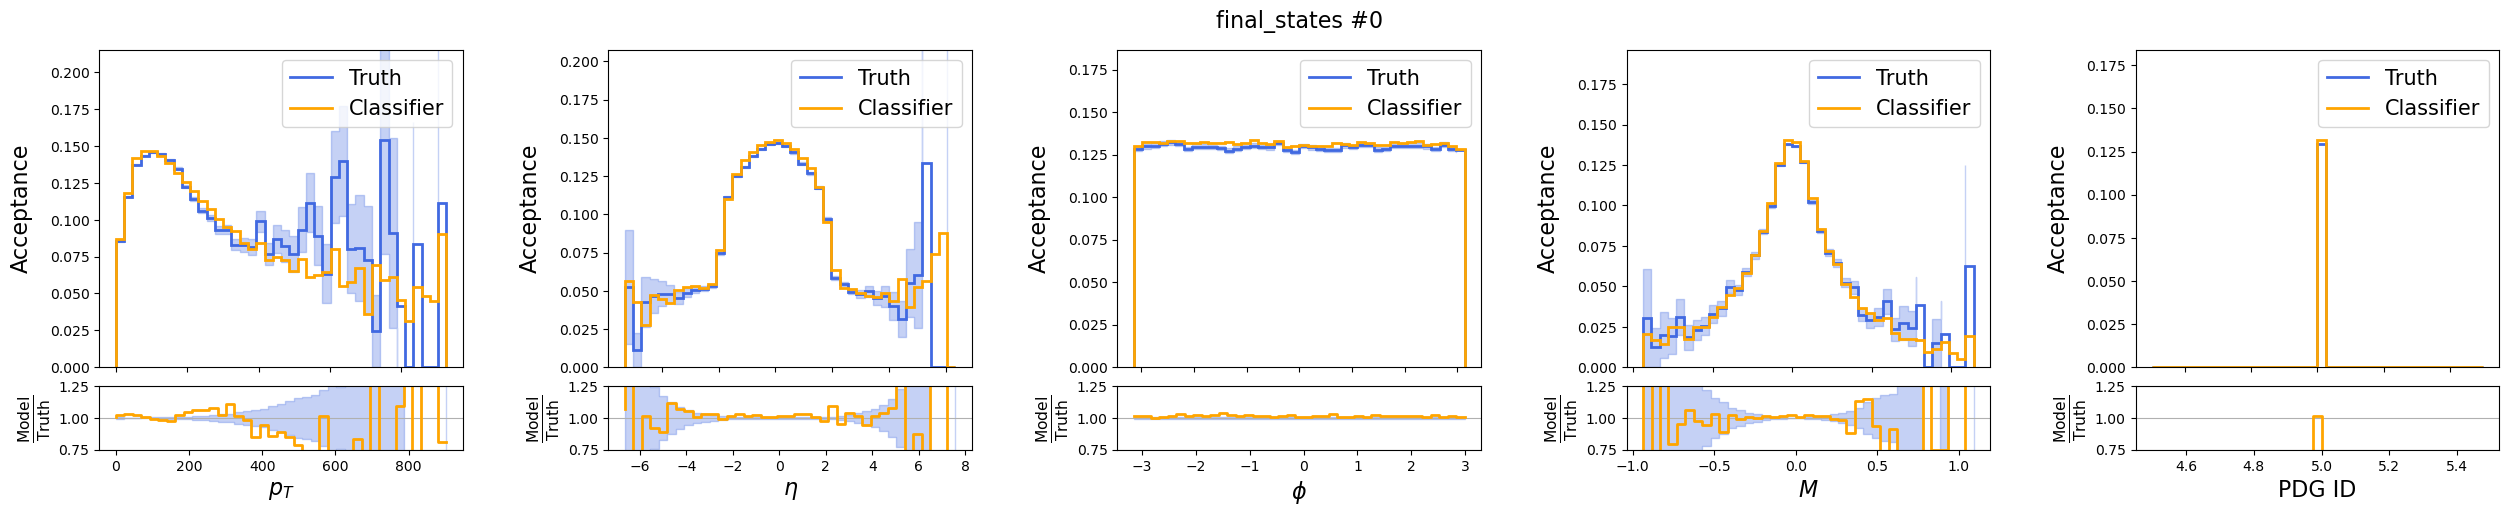

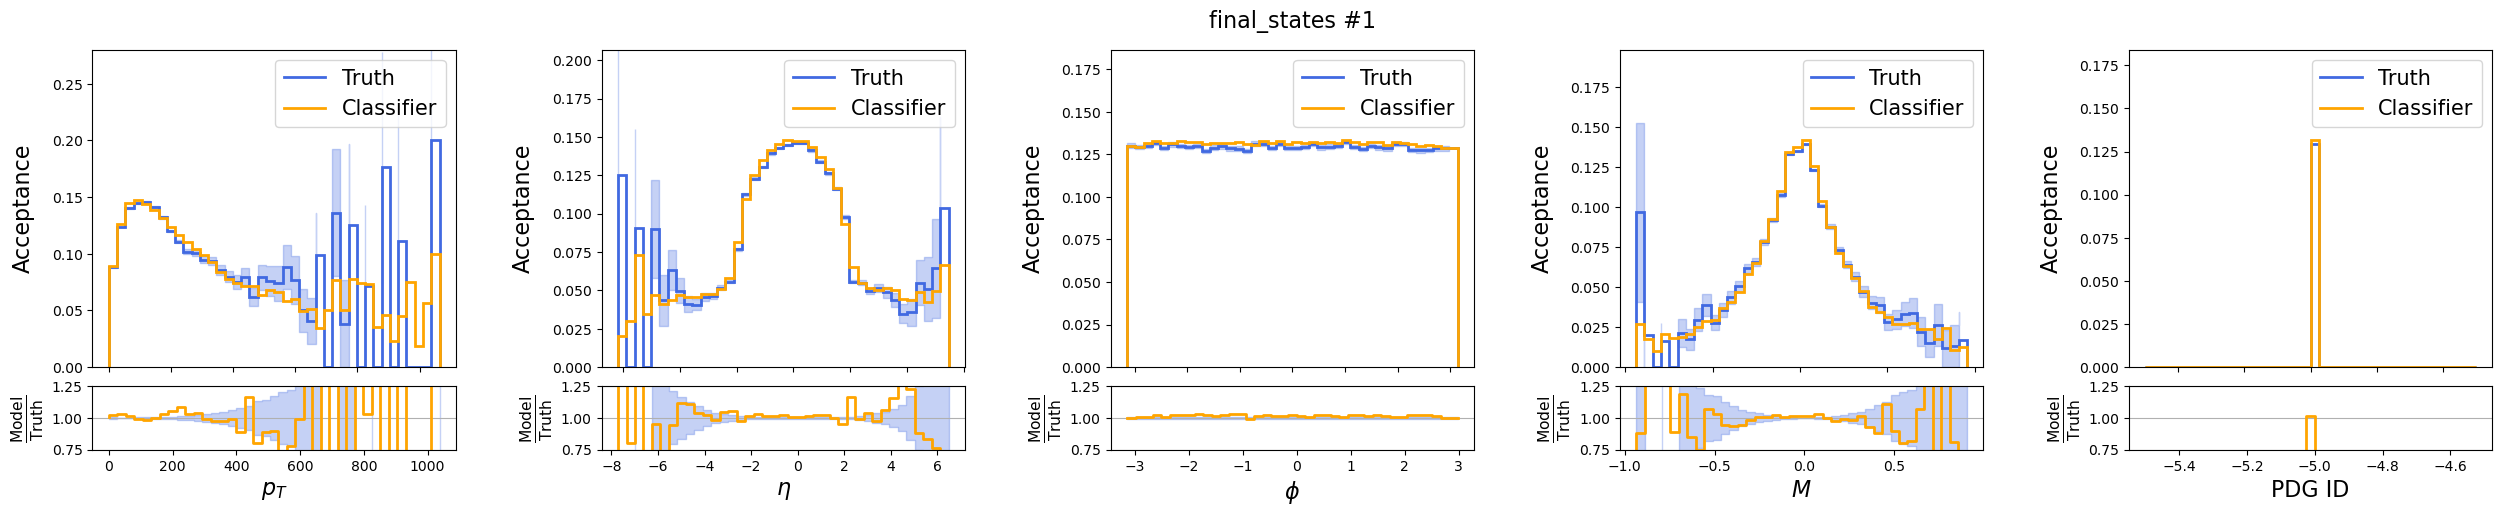

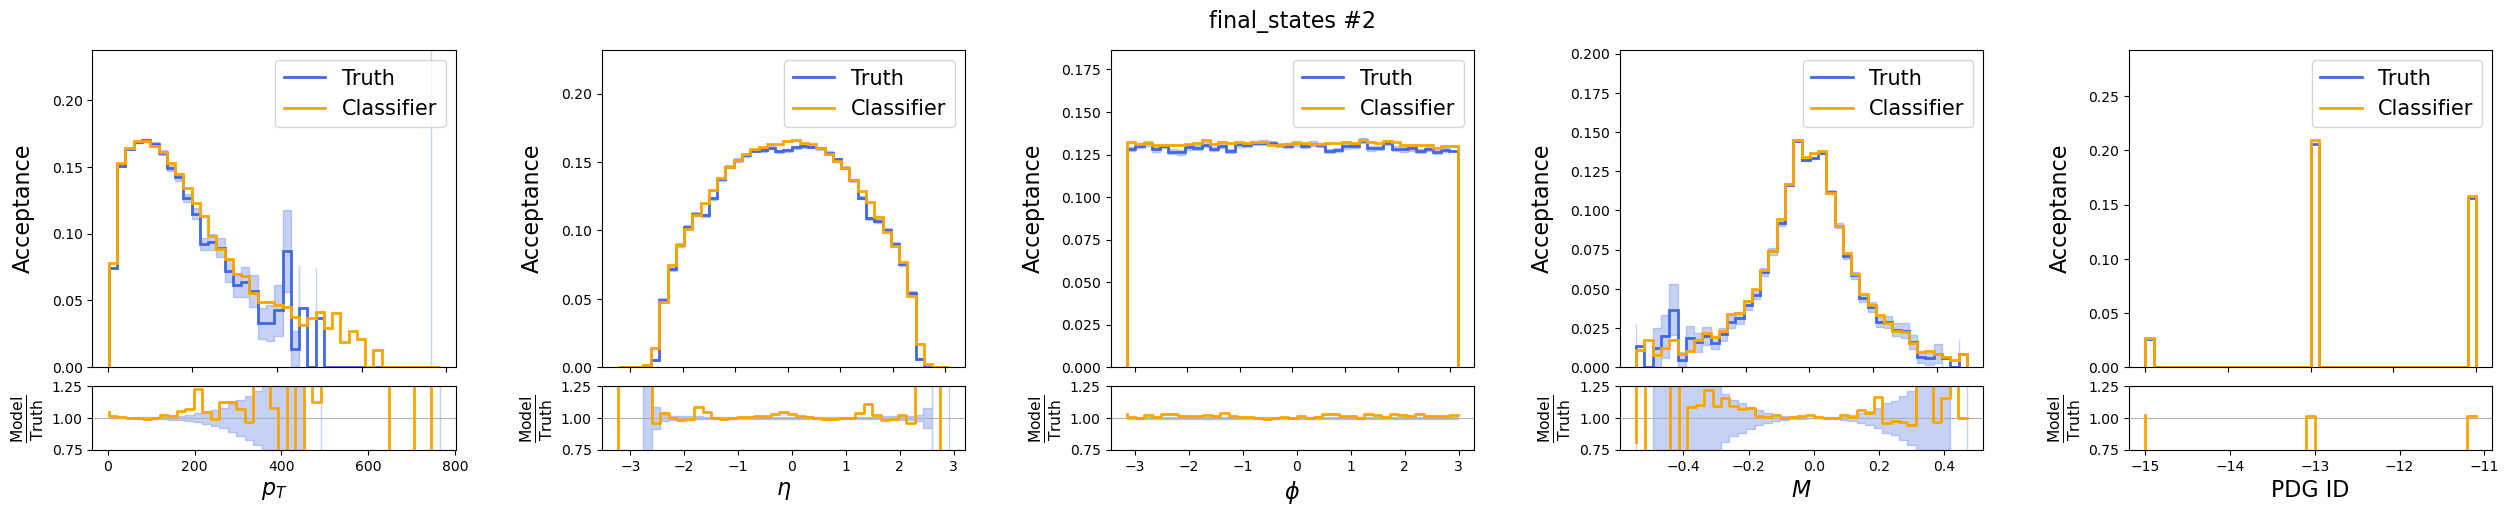

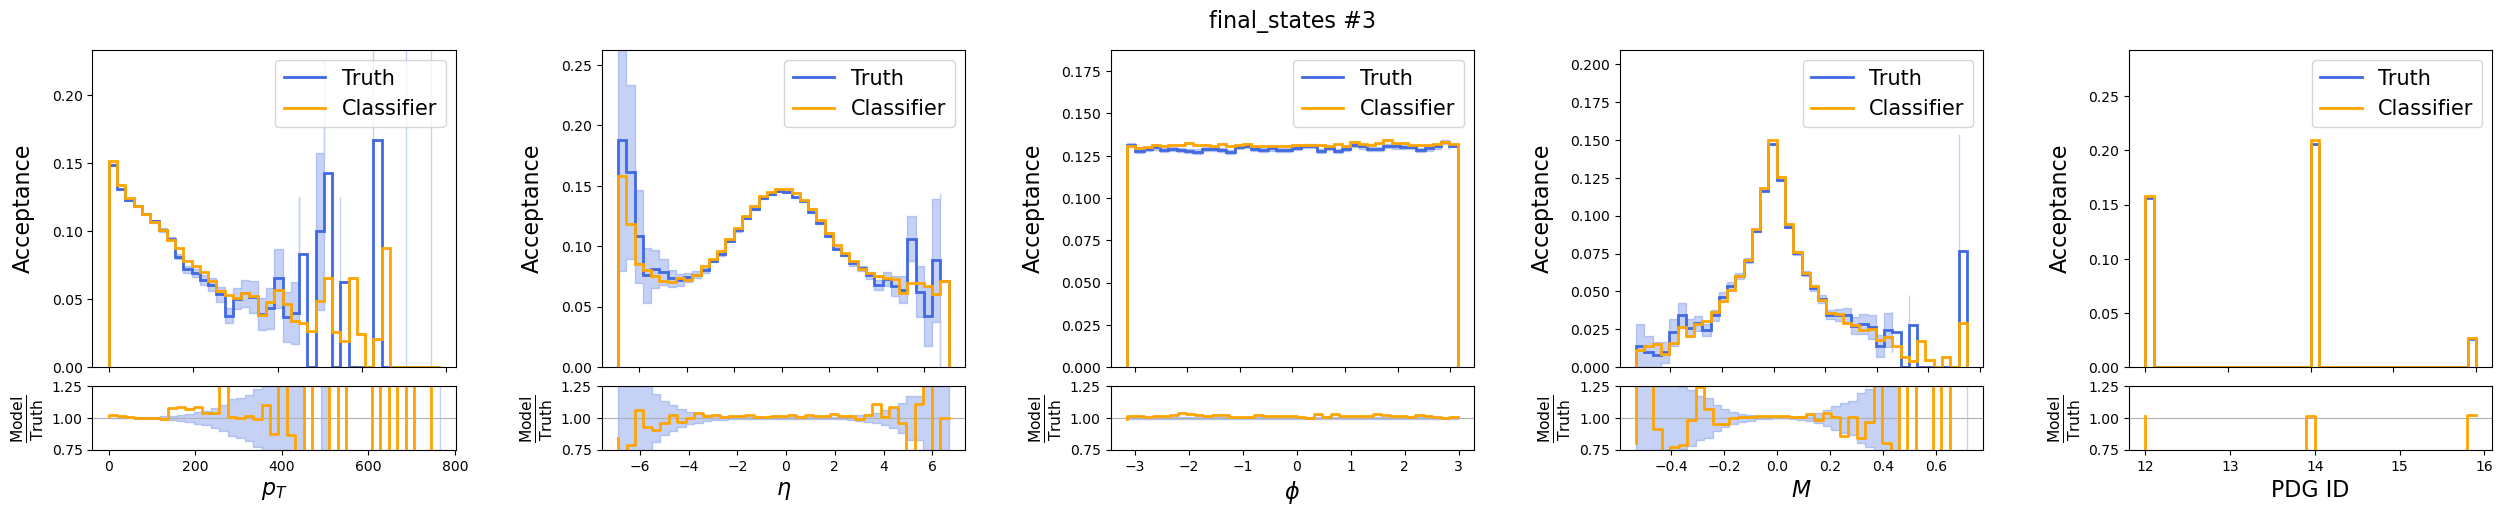

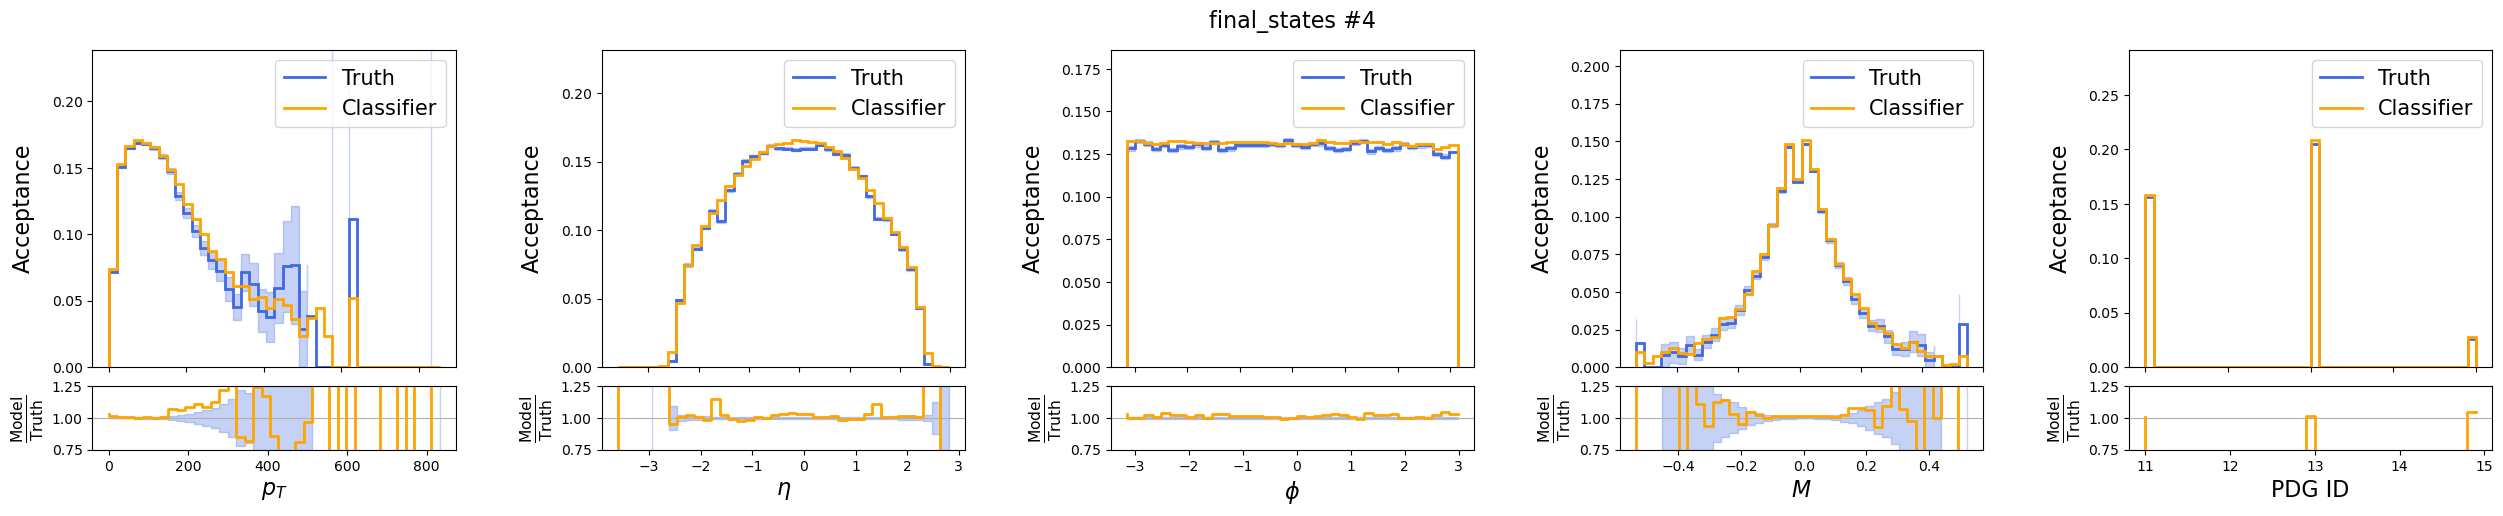

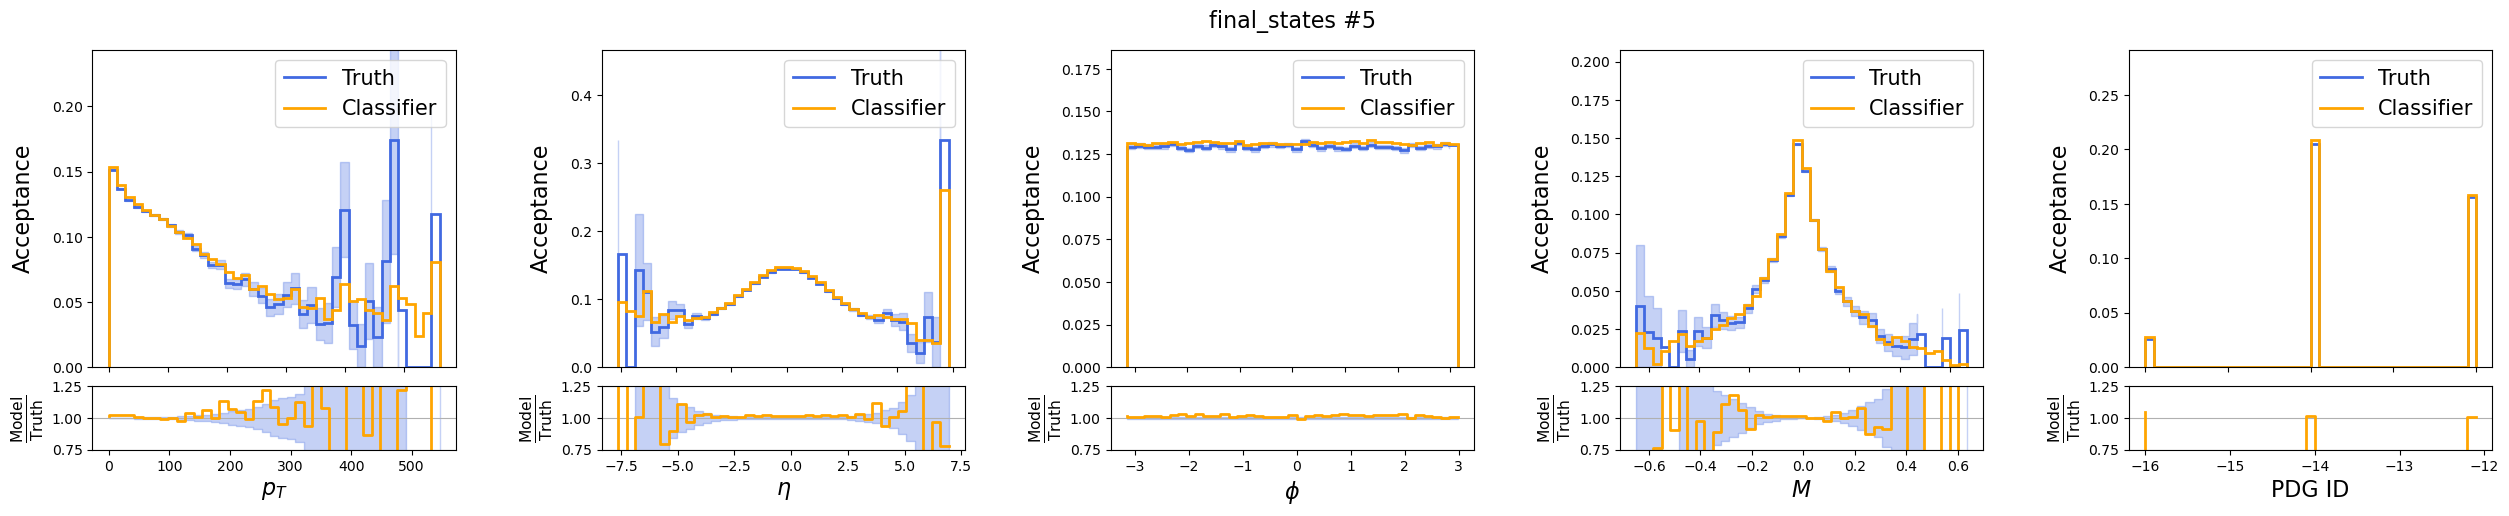

In [7]:
acceptance = AcceptanceCallback(
    dataset = dataset,
    frequency = 5,
    raw = True,
    bins = 40,
    batch_size=10000,
    #N_batch = 1,
    outlier_min = 5,
    label_names = {
        'pt'   : r'$p_T$',
        'eta'  : r'$\eta$',
        'phi'  : r'$\phi$',
        'mass' : r'$M$',
        'pdgId': r'PDG ID',
    }
)
figs = acceptance.make_plots(model=model.cuda(),show=True)

out_dir = f'/home/ucl/cp3/fbury/scratch/MEMFlow_data/acceptance_{suffix}'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

torch.save(
    model,
    os.path.join(
        out_dir,
        'acceptance.pt'
    ),
)

for figname,fig in figs.items():
    fig.savefig(
        os.path.join(
            out_dir,
            figname,
        ), 
    )